# BERT - Baseline
This notebook fine-tunes the bert-based-cased model as a baseline for comparison to the other models trained on a specifc corpus.

BERT was trained on the following corpora:

*   **BooksCorpus:** 800 million words from 11,000+ unpublished books
*   **English Wikipedia:** 2.5 billion words from the entire text from the site

This means that BERT not only understands the patterns in diverse writing styles but also a wide understanding of information from many domains.

BERT used the following training objectives:

*   **Masked Language Model (MLM)**: randomly masked words in a sentence and then tied to predict them; learn bidirectially
*   **Next Sentence Predication (NSP)**: predicts whether a given sentence is the next sentence in a text.





## Imports
Versions were provided where possible.

In [ ]:
print("Versions of Imports")
print("-------------------")

# Data Analysis
import numpy as np
print(f'Numpy: \t\t{np.__version__}')
import pandas as pd
print(f'Pandas: \t{pd.__version__}')

# TensorFlow
import tensorflow as tf
print(f'Tensorflow: \t{tf.__version__}')
from tensorflow import keras

# HuggingFace
from transformers import TFBertForSequenceClassification, BertTokenizer, AdamW
from transformers import InputExample, InputFeatures

# Scikit Learn - Metrics
from sklearn.metrics import classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Google Colab
from google.colab import drive

## Data
The datasets were preprocessed in the EDA notebook and saved as CSVs to my Google Drive. The following block of code mounts to my drive and reads in the data from the three files.

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/'
train_df = pd.read_csv(file_path + 'train_df.csv')
val_df = pd.read_csv(file_path + 'val_df.csv')
test_df = pd.read_csv(file_path + 'test_df.csv')

Mounted at /content/drive


In [ ]:
print(train_df.head())
print(val_df.head())
print(test_df.head())

                                                text labels
0  Penquin can encrypt communications using the B...  T1573
1  Kimsuky to used modified versions of open sour...  T1505
2  FatDuke can use base64 encoding, string stacki...  T1027
3  Files and folders that start with a default, ‘...  T1564
4  LookBack’s C2 proxy tool sends data to a C2 se...  T1071
                                                text labels
0  The Azure CLI  also provides an interface to o...  T1087
1  Proc memory injection is commonly performed by...  T1055
2  SpicyOmelette has collected data and other inf...  T1005
3  After Comnie has been copied to the %TEMP% dir...  T1074
4  Kernel extensions, also called kext, are used ...  T1547
                                                text labels
0  Sandworm Team has event logging on compromised...  T1562
1  Background From October 2012 to May 2014, Fire...  T1071
2  The trap command allows programs and shells to...  T1546
3             APT37 obfuscates strings a

## Hyperparameters
This block of code mimics MITRE's TRAM hyperparameters. The learning rate, number of epochs, batch size and max sequence length all match their hyperparameters. The number of classes is slightly reduced from their number of 50 classes. This is a result of the dataset I found on HuggingFace.

In [ ]:
model_name = 'bert-base-cased'
num_labels = 44
max_length = 512
batch_size = 10
epochs = 5
learning_rate = 2e-5

## Model Architecture
MITRE used the BertForSequenceClassification which is a HuggingFace transformer that includes a classification head (softmax) on top of a pooled output layer. This simplifies the creation of the model and accomplishes the downstream task of performing multiclass classification. All that is needed is the model name and the number of classes which in the case of this experiment is 44.

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name,
                                                        num_labels=num_labels)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize and Encode
Prepare the text data and labels for TF-based BERT classification. The text data is tokenized and encoded to a uniform length (max_length), and the labels are converted to integer (label_map) tensors to be used as target values during model training and evaluation.

The second block of code is necessary to create TF datasets. The training dataset is shuffled to ensure the model doesn't learn any spurious patterns based on the order of the data. Shuffling is not necessary for validation and testing datasets. However, all of the datasets are batched for processing multiple examples in parallel. This is crucial for efficient training and evaluation.

In [ ]:
def encode_texts(texts, tokenizer, max_length=max_length):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )

# Encode the training, validation, and test sets
train_encodings = encode_texts(train_df['text'], tokenizer)
val_encodings = encode_texts(val_df['text'], tokenizer)
test_encodings = encode_texts(test_df['text'], tokenizer)

# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(train_df['labels'].unique())}
train_labels = tf.convert_to_tensor([label_map[label] for label in train_df['labels']])
val_labels = tf.convert_to_tensor([label_map[label] for label in val_df['labels']])
test_labels = tf.convert_to_tensor([label_map[label] for label in test_df['labels']])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                    train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings),
                                                  val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                                   test_labels))

train_dataset = train_dataset.shuffle(len(train_df)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## Optimization, Loss and Evaluation Metric
The choice to use Adam for the optimizer instead of AdamW was a technical one. AdamW is an extension of Adam that includes decoupled weight decay regularization. This helps prevent overfitting by adding a penalty to the loss function proportional to the sum of the squared weights. [Loshchilov et. al.](https://arxiv.org/pdf/1711.05101) explains the differences between the two far better than I can here.

Basically, I decided to stay with the default value of 0 for the Adam weight decay (L2 regularization) because if I matched the value to the AdamW optimizer I would be impacting the gradients during backpropagation. Since AdamW decouples weight decay from gradiant updates I felt this was the best approach to ensure somewhat of a level playing field.

Sparse Categorical Crossentropy is used for multiclass classification tasks where the labels are integers rather than one-hot encoded vectors. The from_logits=True parameter indicates that the model's output is not normalized (i.e., not passed through a softmax function), which is typically the case when using models like BERT that output raw logits.

Sparse Categorical Accuracy evaluate the model's performance and is appropriate for multiclass classification tasks with integer labels measuring the percentage of correctly predicted labels.

The final step in this code block compiles the model for training by configuring it with the optimizer, loss function and evaluation metric.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metric])

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  33836     
                                                                 
Total params: 108344108 (413.30 MB)
Trainable params: 108344108 (413.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_history = model.fit(train_dataset,
                          validation_data=val_dataset,
                          batch_size=batch_size,
                          epochs=epochs)

Epoch 1/5
1218/1218 [==============================] - 1461s 1s/step - loss: 2.1018 - accuracy: 0.5431 - val_loss: 0.8453 - val_accuracy: 0.8273
Epoch 2/5
1218/1218 [==============================] - 1421s 1s/step - loss: 0.5742 - accuracy: 0.8770 - val_loss: 0.5192 - val_accuracy: 0.8772
Epoch 3/5
1218/1218 [==============================] - 1421s 1s/step - loss: 0.2511 - accuracy: 0.9434 - val_loss: 0.4537 - val_accuracy: 0.8871
Epoch 4/5
1218/1218 [==============================] - 1421s 1s/step - loss: 0.1249 - accuracy: 0.9727 - val_loss: 0.4844 - val_accuracy: 0.8858
Epoch 5/5
1218/1218 [==============================] - 1421s 1s/step - loss: 0.0767 - accuracy: 0.9839 - val_loss: 0.4412 - val_accuracy: 0.9028


This code block was taken and modified from Assignment 2: Text Classification with Various Neural Networks notebook.

As you can see from the graphs created below, the training loss appears to be approaching zero suggesting a potential overfitting. However, the validation loss continues to fall, albeit slowly. As you can see in the second cell, the model generalizes well with the test accuracy of 90%.

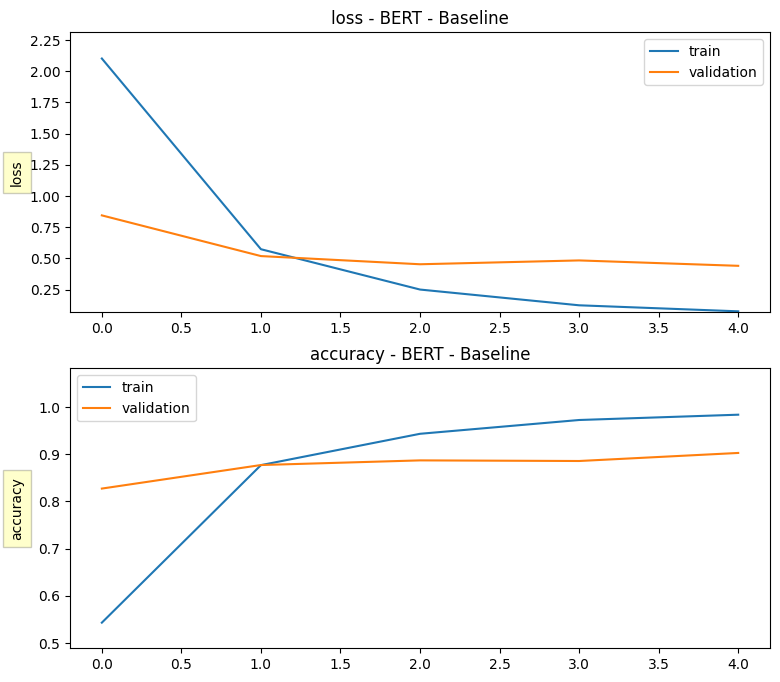

In [ ]:
def make_plot(axs, model_history, model_name='model'):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower = np.min(model_history.history[metric]) * 0.9
        y_lim_upper = np.max(model_history.history[metric]) * 1.1

        ax1 = axs[i]
        ax1.plot(model_history.history[metric], label='train')
        ax1.plot(model_history.history['val_%s' % metric], label='validation')
        ax1.set_title('%s - %s' % (metric, model_name))
        ax1.set_ylabel(metric, bbox=box)
        ax1.set_ylim(y_lim_lower, y_lim_upper)
        ax1.legend()

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, model_history, model_name='BERT - Baseline')
fig.align_ylabels(axs)
fig.set_size_inches(10, 8)
plt.show()


In [ ]:
results = model.evaluate(test_dataset)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

153/153 [==============================] - 63s 411ms/step - loss: 0.4388 - accuracy: 0.9048
Test Loss: 0.43875497579574585
Test Accuracy: 0.9047931432723999


## Classification Report
Overall accuracy is good but it doesn't show how each class if performing. To get that information we need to use SciKit Learn's Classification Report.

In order to get that report we need to get the predictions on the test dataset. These produce the logits for each class. The use of np.argmax is necessary to return the class with the highest probability. Also the test labels need to be converted to a numpy array for use with the Classification Report. These are the ground truth. Finally, label_map is used to return the target class names.

All of these are sent as parameters to the Classification Report to find out the model's performance over each of the classes. The precision, recall and F1-score are returned.

In [ ]:
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions.logits, axis=1)

153/153 [==============================] - 65s 409ms/step


In [ ]:
true_labels = test_labels.numpy()
target_names = list(label_map.keys())

In [ ]:
report = classification_report(true_labels,
                               predicted_labels,
                               target_names=target_names)
print(report)

              precision    recall  f1-score   support

       T1573       0.95      0.90      0.92        20
       T1505       0.95      0.98      0.96        42
       T1027       0.89      0.89      0.89        47
       T1564       0.89      0.80      0.84        20
       T1071       0.98      0.93      0.95        45
       T1059       0.79      0.85      0.82        53
       T1074       0.98      1.00      0.99        45
       T1132       0.93      1.00      0.96        40
       T1574       0.88      0.68      0.77        22
       T1560       0.95      0.95      0.95        40
       T1113       0.97      1.00      0.99        36
       T1102       0.87      0.93      0.90        43
       T1553       0.92      0.71      0.80        31
       T1140       0.96      0.83      0.89        29
       T1543       0.89      0.94      0.91        17
       T1562       0.68      0.86      0.76        22
       T1005       0.91      0.91      0.91        55
       T1106       0.83    

In [ ]:
confusion_mtx = tf.math.confusion_matrix(true_labels, predicted_labels)
print(confusion_mtx)

tf.Tensor(
[[18  0  0 ...  0  0  0]
 [ 0 41  0 ...  0  0  0]
 [ 0  0 42 ...  0  0  0]
 ...
 [ 0  0  0 ... 16  0  2]
 [ 0  0  0 ...  0 21  0]
 [ 0  0  0 ...  1  0 18]], shape=(44, 44), dtype=int32)


Text(220.72222222222223, 0.5, 'True')

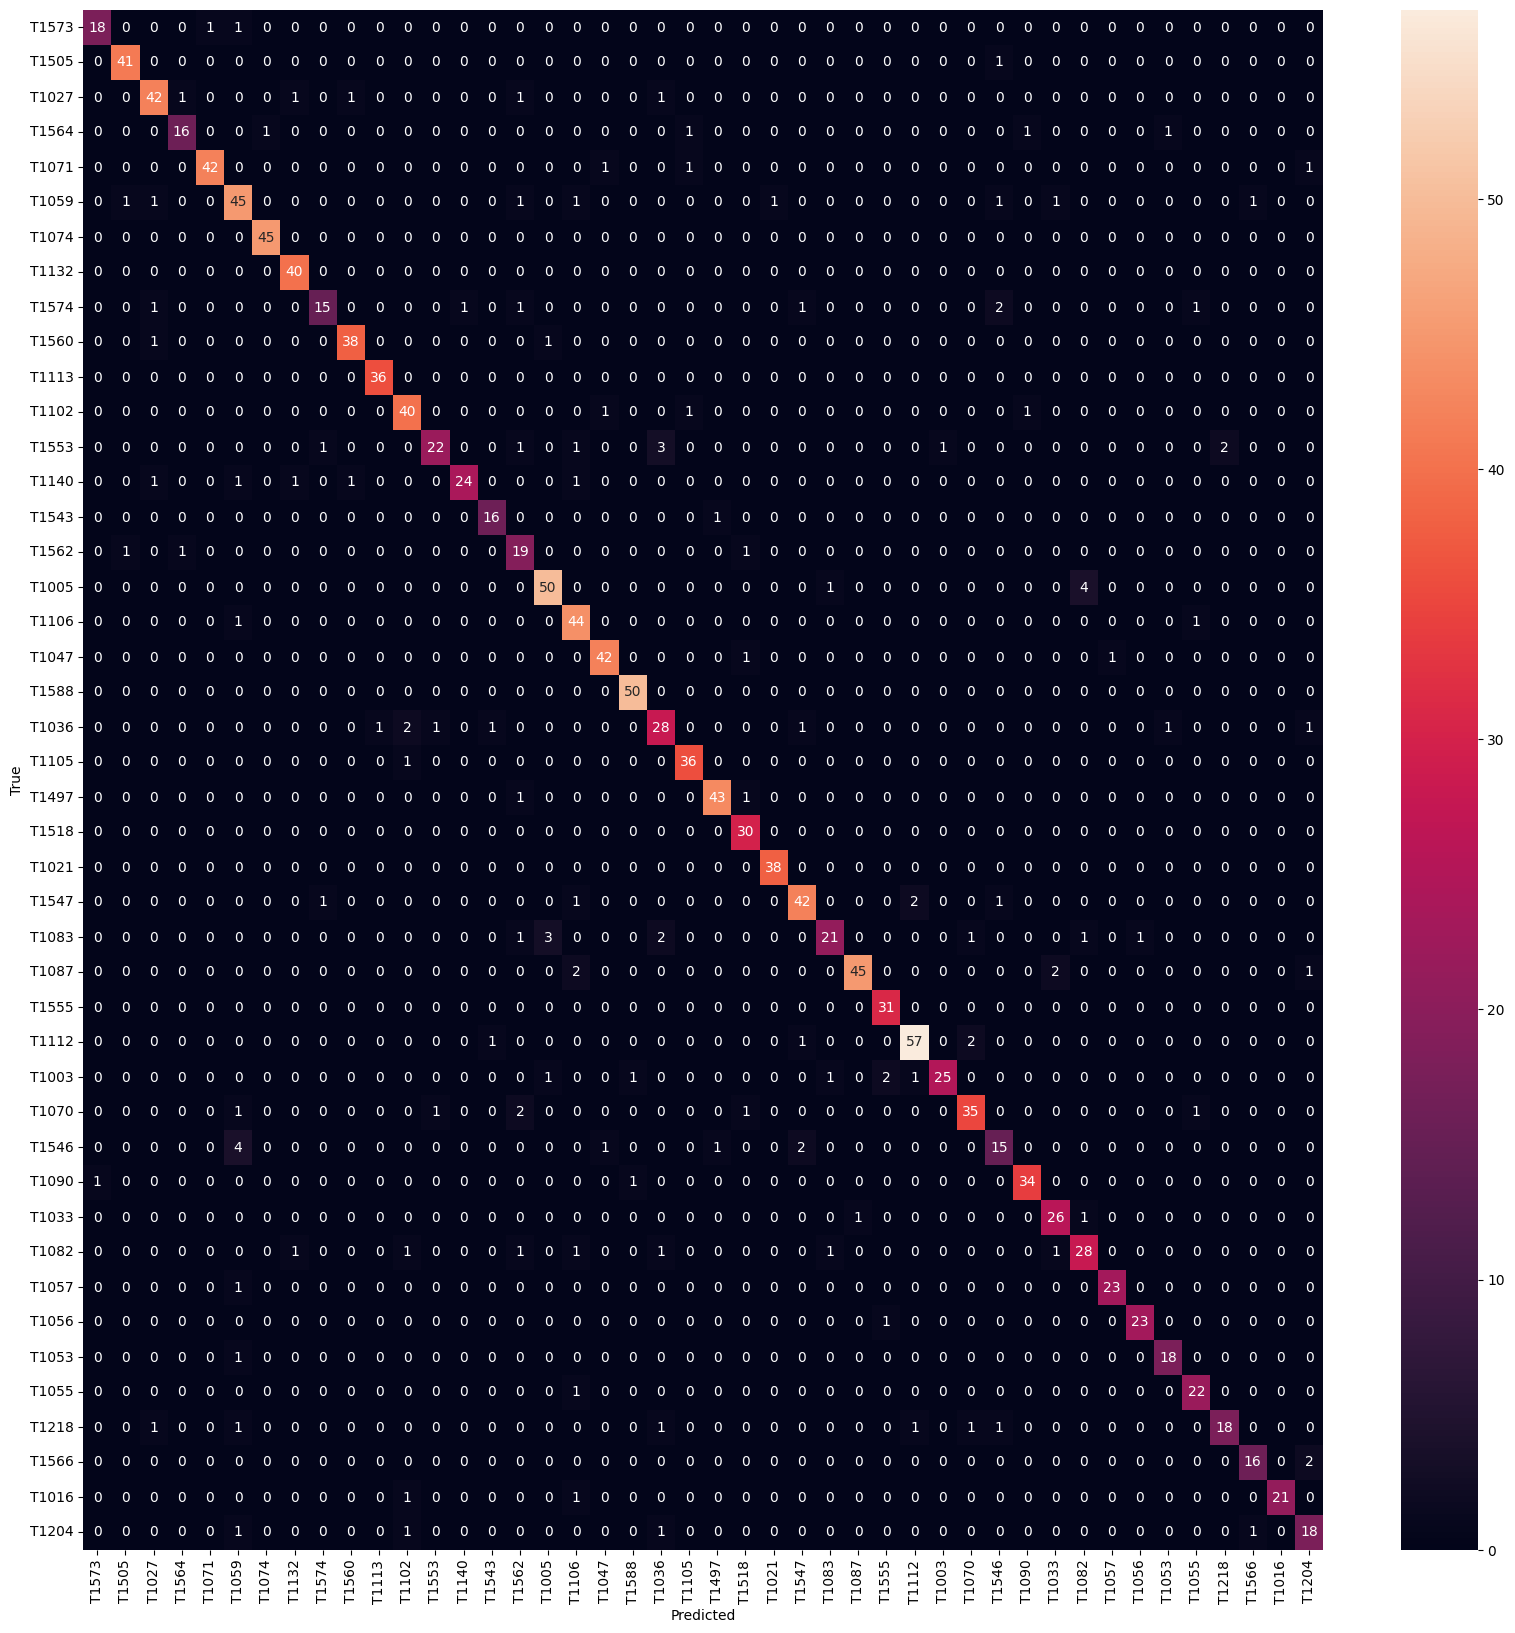

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(
    confusion_mtx, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")